# Projet Deep Learning
## Valentin Huyenh et Bastien Lozac'h

Le projet consiste à entrainer un réseau de neuronne pour identifier le premier chiffre d'une plaque de numéro d'immeuble.
Ce sujet a été choisit car il combine à la fois le repérage d'un symbole simple comme un chiffre imprimée mais aussi l'élimination du bruit, vu qu'ici, seul le nombre de gauche nous interesse.

Nous utilisons comme base d'image une extraction de la base en ligne suivante :
http://ufldl.stanford.edu/housenumbers/

Nous avons selectionné un peu moins de 700 images pour faire nos tests.


# Import

On regroupe ici les imports pour simplifier le reste du code

In [31]:
import os
import glob
import numpy as np

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from keras.layers import Flatten

from keras import Model
from keras.layers import Dense
from keras import optimizers

from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import keras

from PIL import Image


# I. Transfert Learning

Pour le transfert Learning, nous nous somme appuyés sur le model VGG16

## A. Lecture du dataset

In [27]:
all_images = []
image_arrays = []
image_arrays_bw = []
all_labels = []
for class_id, label in enumerate(os.listdir("../data/project_data")):
    print(label)
    for filename in glob.glob('../data/project_data/{}/*'.format(label)):
        im = load_img(filename, target_size=(224, 224))
        all_images.append(im) 
        image_arrays.append(img_to_array(im))
        image_arrays_bw.append(img_to_array(im.convert('L'))) ##version noir et blanc
        all_labels.append(class_id)
X_bw = np.array(image_arrays_bw)
X = preprocess_input(np.array(image_arrays))
Y = to_categorical(np.array(all_labels))

1
2
3
4
5
6
7
8
9


## B. Séparation entre train et test

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.15, random_state=42)

## C. Récuperation du model VGG16

In [4]:
model_cut = VGG16(weights="imagenet", include_top=False,
                  input_shape=(224, 224, 3))

## D. Création du model

In [5]:
## On ne reentraine pas les couches de VGG16
for layer in model_cut.layers : 
	layer.trainable = False ;

## Output de VGG16
x = model_cut.output

##Ajout de nos couches
prediction_layer = x
prediction_layer = Flatten()(prediction_layer)
prediction_layer = Dense(15, activation='relu')(prediction_layer)
prediction_layer = Dense(9, activation='softmax')(prediction_layer)

#Creation de notre modele
new_model = Model(
    inputs=model_cut.input,
    outputs=prediction_layer)

# Compiler le modèle 
new_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
    metrics=["accuracy"])

## E. Entrainement

In [6]:
epochs = 5 ; ##nombre de passe
batch_size = 10##nombre de donnée traité en une fois,bien pour diminuer le cout en mémoire
model_info = new_model.fit(
    X_train, Y_train,
    epochs=epochs, 
    batch_size=batch_size)

Epoch 1/5
503/503 [==============================] - 275s 548ms/step - loss: 2.6627 - acc: 0.1412
Epoch 2/5
503/503 [==============================] - 266s 528ms/step - loss: 2.1751 - acc: 0.1829
Epoch 3/5
503/503 [==============================] - 269s 535ms/step - loss: 2.1662 - acc: 0.1829
Epoch 4/5
503/503 [==============================] - 278s 554ms/step - loss: 2.1645 - acc: 0.1829
Epoch 5/5
503/503 [==============================] - 287s 570ms/step - loss: 2.1618 - acc: 0.1829


## F. Test de prédiction

In [7]:
    ##predict
index =17
image = all_images[index]
new_model.predict(image_arrays[index].reshape(1,224,224,3))



array([[0.11149342, 0.11270385, 0.11183861, 0.1112076 , 0.11077846,
        0.11115117, 0.11074772, 0.11010646, 0.1099727 ]], dtype=float32)

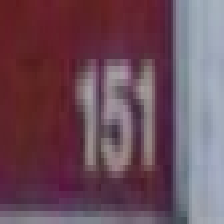

In [8]:
image

## G. Analyse du Résultat

Le résultat que nous obtenons avec ce model n'est pas très bon. Le temps d'entrainement est exessivement long sur nos machines, et la précision reste très faible.

C'est surement parce que VGG16 est plus adapté à la reconnaissance d'objet qu'à la reconnaissance de caractères, sans parler de la qualité de nos images, qui sont, il faut bien le reconnaitre, pas très bonne.

Nous allons donc essayer de créer notre propre model, de A à Z, pour comparer

# II. Deep Learning other Model

## A. Initialisation

In [29]:
## Nombres de classes différentes
nbr_classes = 9

# input image dimensions
img_rows, img_cols = 224, 224

## split
X_train, X_test, Y_train, Y_test = train_test_split(X_bw, Y, test_size=0.15, random_state=42)

##changer de type pour eviter le troncage lors de la division par 255
##valeurs de 0 a 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

##test pour verifier la version de keras
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


## B. Création du Model

In [32]:
simple_model = Sequential()
simple_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    ##Conv2D, permet de lisser l'image pour eliminer les artefacts
simple_model.add(Conv2D(64, (3, 3), activation='relu'))
simple_model.add(MaxPooling2D(pool_size=(2, 2)))
    ##MaxPooling2D, prend la plute forte valeur dans un filtre, ici 2*2
simple_model.add(Dropout(0.25))
    ##Elimine un pourcentage de neuronne, ici 25%
simple_model.add(Flatten())
    ##2 dimensions -> 1 dimension
simple_model.add(Dense(128, activation='relu'))
simple_model.add(Dropout(0.5))
simple_model.add(Dense(nbr_classes, activation='softmax'))

##Compile
simple_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])



## C. Entrainement du Model

In [33]:
##fit
epochs = 5 ; ##nombre de passe
batch_size = 10##nombre de donnée traité en une fois,bien pour diminuer le cout en mémoire
simple_model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs)

##test du score
score = simple_model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
503/503 [==============================] - 240s 478ms/step - loss: 2.7057 - acc: 0.1590
Epoch 2/5
503/503 [==============================] - 232s 462ms/step - loss: 2.2254 - acc: 0.1769
Epoch 3/5
503/503 [==============================] - 255s 506ms/step - loss: 2.1750 - acc: 0.1869
Epoch 4/5
503/503 [==============================] - 258s 512ms/step - loss: 2.1140 - acc: 0.2346
Epoch 5/5
503/503 [==============================] - 255s 508ms/step - loss: 1.8412 - acc: 0.3817
Test loss: 2.5375995180580055
Test accuracy: 0.12359550461340486


## D. Test du model

In [37]:
    ##predict
index =17
image = all_images[index]
simple_model.predict(image_arrays_bw[index].reshape(1,224,224,1))

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

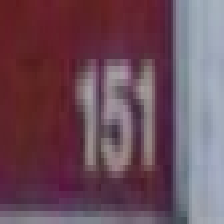

In [38]:
image

## E. Analyse du Résultat

Le résultat de ce second model reste mauvais, mais progresse néanmoins rapidement à chaque itération. On peut penser qu'en le laissant tourner plus longtemps, on aurait un résultat correct. Malgré, tout, il faut tout de même se méfier, la précision sur les valeurs de test sont bien plus faible que celle obtenu sur celle de train. Il se peut que le modele aprenne les mauvais pattern, à cause d'un mauvais choix d'image d'entrainement.

# III. Limites

Nos model de Deep Learning ne sont pas très bon, mais notre question est difficile, et nous avons probablement que trop peu d'images (seulement 700) pour réellement avoir des résultats fiables.

Celà serait néanmoins interressant de réessayer sur des machines plus performantes et avec un plus grand nombre de boucle, pour voir si c'est un problème de conception, ou juste de temps de calcul.